# Project 1 Notebook

## Introduction

This notebook contains all relevant code and annotation associated with completing the project's objective. For access to all data and code used, please refer to my GitHub page (https://github.com/Lucmeister55/MLLS_Project1).

## Raw data Import

We start by importing all raw datasets available to us.

### Test Dataset

First of all, test set data was downloaded from the kaggle competition page (https://www.kaggle.com/competitions/bicycle-counter-prediction/data) and is read into memory by this chunk. These measurements represent only around 48% of the full test set, and are summed across every hour. Nevertheless, the test set encompasses the whole of the month of July 2023. The reduced test set size, time range and first few rows are listed below the chunk.

In [31]:
import pandas as pd
import numpy as np
import datetime

test_rawdata = pd.read_csv("input/bicycle-counter-prediction/test_data.csv")
print(test_rawdata.shape)
print(min(test_rawdata["Date_hour"]))
print(max(test_rawdata["Date_hour"]))
test_rawdata.head()

(744, 2)
2023-07-01T00
2023-07-31T23


,Id,Date_hour
0,0,2023-07-01T00
1,1,2023-07-01T01
2,2,2023-07-01T02
3,3,2023-07-01T03
4,4,2023-07-01T04


### Bycicle measurements

Bycicle measurements from the Coupure Links were downloaded from the Ghent Open Data Portal (https://data.stad.gent/explore/?disjunctive.keyword&disjunctive.theme&sort=modified) and subsequently saved by year in the following chunk. Currently, these are expressed as the sum of cyclists passing every five minutes.

In [32]:
# read in data
coupurelinks_2021 = pd.read_csv("input/bicycle-counter-prediction/fietstelpaal-coupure-links-2021-gent.csv", sep = ";")
coupurelinks_2022 = pd.read_csv("input/bicycle-counter-prediction/fietstelpaal-coupure-links-2022-gent.csv", sep = ";")
coupurelinks_2023 = pd.read_csv("input/bicycle-counter-prediction/fietstelpaal-coupure-links-2023-gent.csv", sep = ";")


Next, these measurements separated by year are concatenated into one comprehensive dataframe. Anyone reading this has every right to sue me for bad database management. The full time range of said dataset is also printed underneath the chunk.

In [33]:
coupurelinks = pd.concat([coupurelinks_2021, coupurelinks_2022, coupurelinks_2023])
bicycle_data = coupurelinks.copy()
coupurelinks = coupurelinks.rename(columns = {"Totaal": "Totaal_CL"})
print("CL")
print(min(coupurelinks["Datum"]))
print(max(coupurelinks["Datum"]))


CL
2021-03-01
2023-07-31


Unfortunately, it seems that certain count measurements are missing from the bicycle counter dataset downloaded. This is also mentioned in the corresponding browser overview page of the database portal. Preprocessing of this data will thus be in order.

In [34]:
print(bicycle_data.isna().sum())

Code               0
Locatie             0
Datum               0
Uur5Minuten         0
Ordening            0
Totaal           4032
Tegenrichting    4032
Hoofdrichting    4032
dtype: int64


### Weather

Weather features are also likely to be correlated with an individual's likelihood to cycle, making this is an easy addition. This data was abtained from Open Meteo (https://open-meteo.com/en/docs/historical-weather-api#latitude=51.05&longitude=3.7167). Chosen features include the objective and apparent temperature, precipation in mm (rain and snow), cloud cover at all altitudes, and whether a time point is considered day or nighttime. Of the 33576 rows in this dataset, 24 rows contain missing values. Since their fraction is negligible, we instead simply remove these rows entirely rather than imputing them.

- Objective temperature (float): Black box ambient temperature without taking wind, etc. into account.
- Apparent temperature (float): Temperature "felt" by humans taking into account all other contributive environmental effects.
- Precipitation (float): Excessive rainpour and snow accumulation can make cycling uncomfortable and/or dangerous.
- Cloud cover (float): Correlated with rain showers, storms, temperature, and sun radiation, and thus plays a large factor in how pleasant it is percieved to be to cycle.
- Day boolean (log): During daytime compared to nighttime, conditions are generally better to cycle, whilst also incorporating the societal "active" hours.

It should be mentioned, that weather effects alone will most likely not suffice to accurately predict the number of cyclists for a given period of time. We will illustrate this by using the temperature feature as an example. Generally, the colder it is, the less inclined an individual might be to cycle. However, this is not a linear or independent relationship, since warm temperatures are more common during summertime, even though cyclists are less active during these months due to the holiday season being in effect (since students and the working class make up the largest fraction of said cyclists). Additional features will be necessary to capture these seasonal dependencies.

In [35]:
# read in data
weather_rawdata = pd.read_csv("input/bicycle-counter-prediction/open-meteo-51.07N3.71E13m.csv", skiprows=2).dropna()
print(weather_rawdata.shape)
weather_rawdata.head()

(33576, 9)


,time,temperature_2m (°C),apparent_temperature (°C),precipitation (mm),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),is_day ()
0,2020-01-01T00:00,3.3,-0.1,0.0,44.0,49.0,0.0,0.0,0
1,2020-01-01T01:00,2.8,-0.6,0.0,17.0,19.0,0.0,0.0,0
2,2020-01-01T02:00,2.5,-1.0,0.0,10.0,11.0,0.0,0.0,0
3,2020-01-01T03:00,1.9,-1.6,0.0,3.0,3.0,0.0,0.0,0
4,2020-01-01T04:00,1.4,-2.2,0.0,0.0,0.0,0.0,0.0,0


### School Holidays

It is reasonable to assume that the school holidays of the lower academic institutes (primary and secondary school) will have an impact on the activity of cyclists in the region. After all, there is a school just across the river from the bike counter in question (Coupure Links). During the holidays, less students and potentially their parents will cycle past this location.

In [36]:
school_holidays_data = pd.read_csv("input/bicycle-counter-prediction/school_holidays.csv", sep = ";")

import datetime
school_holidays = {}
for index, row in school_holidays_data.iterrows():
    school_holidays[row['name']] = [datetime.datetime.strptime(row['start'], '%Y-%m-%d'), datetime.datetime.strptime(row['end'], '%Y-%m-%d')]
print(school_holidays)

{'Christmas holiday 2020': [datetime.datetime(2020, 12, 21, 0, 0), datetime.datetime(2021, 1, 3, 0, 0)], 'Spring break 2021': [datetime.datetime(2021, 2, 15, 0, 0), datetime.datetime(2021, 2, 21, 0, 0)], 'Easter holiday 2021': [datetime.datetime(2021, 4, 5, 0, 0), datetime.datetime(2021, 4, 18, 0, 0)], 'Summer holiday 2021': [datetime.datetime(2021, 7, 1, 0, 0), datetime.datetime(2021, 8, 31, 0, 0)], 'Autumn break 2021': [datetime.datetime(2021, 11, 1, 0, 0), datetime.datetime(2021, 11, 7, 0, 0)], 'Christmas holiday 2021': [datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 1, 9, 0, 0)], 'Spring break 2022': [datetime.datetime(2022, 2, 28, 0, 0), datetime.datetime(2022, 3, 6, 0, 0)], 'Easter holiday 2022': [datetime.datetime(2022, 4, 4, 0, 0), datetime.datetime(2022, 4, 18, 0, 0)], 'Summer holiday 2022': [datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2022, 8, 31, 0, 0)], 'Autumn break 2022': [datetime.datetime(2022, 10, 31, 0, 0), datetime.datetime(2022, 11, 6, 0, 

### Public holidays

Plenty of people cycle to their work. During public holidays, their contribution to the counter will surely decrease.

In [37]:
import holidays
belgian_holidays = holidays.Belgium(years=[2021, 2022, 2023])
print(belgian_holidays)

{datetime.date(2021, 1, 1): 'Nieuwjaar', datetime.date(2021, 4, 4): 'Pasen', datetime.date(2021, 4, 5): 'Paasmaandag', datetime.date(2021, 5, 1): 'Dag van de Arbeid', datetime.date(2021, 5, 13): 'O. L. H. Hemelvaart', datetime.date(2021, 5, 23): 'Pinksteren', datetime.date(2021, 5, 24): 'Pinkstermaandag', datetime.date(2021, 7, 21): 'Nationale feestdag', datetime.date(2021, 8, 15): 'O. L. V. Hemelvaart', datetime.date(2021, 11, 1): 'Allerheiligen', datetime.date(2021, 11, 11): 'Wapenstilstand', datetime.date(2021, 12, 25): 'Kerstmis', datetime.date(2022, 1, 1): 'Nieuwjaar', datetime.date(2022, 4, 17): 'Pasen', datetime.date(2022, 4, 18): 'Paasmaandag', datetime.date(2022, 5, 1): 'Dag van de Arbeid', datetime.date(2022, 5, 26): 'O. L. H. Hemelvaart', datetime.date(2022, 6, 5): 'Pinksteren', datetime.date(2022, 6, 6): 'Pinkstermaandag', datetime.date(2022, 7, 21): 'Nationale feestdag', datetime.date(2022, 8, 15): 'O. L. V. Hemelvaart', datetime.date(2022, 11, 1): 'Allerheiligen', datetim

## Mundane data preprocessing

### Bicycle measurements

To solve the problem of missing values, these entries will be imputed using a simple imputer, which replaces missing values using a descriptive statistic along each column (in this case, the mean of that column). Furthermore, the measurements are transformed to instead be summed across every hour to be in line with the test set.

In [38]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

bicycle_data["Date_hour"] = bicycle_data['Ordening'].str.extract(r'^(.*?T\d{2})..')

imputer = SimpleImputer()
bicycle_imputed = imputer.fit_transform(bicycle_data.filter(regex='^Totaal', axis=1))
bicycle_data[bicycle_data.filter(regex='^Totaal', axis=1).columns] = bicycle_imputed

bicycle_data = bicycle_data.groupby(['Datum', 'Date_hour']).agg({'Totaal': 'sum'}).reset_index()
print(bicycle_data.shape)
print(min(bicycle_data["Date_hour"]))
print(max(bicycle_data["Date_hour"]))

bicycle_data.head()

(21189, 3)
2021-03-01T00
2023-07-31T23


,Datum,Date_hour,Totaal
0,2021-03-01,2021-03-01T00,5.0
1,2021-03-01,2021-03-01T01,1.0
2,2021-03-01,2021-03-01T02,0.0
3,2021-03-01,2021-03-01T03,2.0
4,2021-03-01,2021-03-01T04,21.0


As we can see, there are no longer any missing values present in the dataset after imputation.

In [39]:
print(bicycle_data.isna().sum())

Datum        0
Date_hour    0
Totaal       0
dtype: int64


To deal with auto-correlation, we will add a transformed Coupure Links response ("Totaal") column as a feature, lagged by one year with respect to the time point indexation. Once again, imputation of missing values will have to be performed, both on the raw Coupure Links dataset, as well as the lagged variables after addition (since there is no lagged data for e.g., 2020). 
 
Ideally, we would add lagged variables from other bike counters in Ghent, such as Groendreef and Isabellakaai. These would have to be lagged by at least 31 days, as they would otherwise include measurements from July 2023, a notion which was explicitly banned for this competition. If sufficiently lagged, these features in theory do not violate this rule. For example, if we add the response ("Totaal") lagged by one year ("LaggedTotaal_CL_year") as a feature, the latest data point in the test set (31-07-2023) would correspond by index with a measurement from 31-07-2022 in the feature vector, thus not alllowing any actual measurements from July 2023 to leak into our training or test set. Nevertheless, we choose here not to include any other bike counters besides those from the Coupure Links (lagged or otherwise), for fear of false interpretation.

In [40]:
coupurelinks["Date_hour"] = coupurelinks['Ordening'].str.extract(r'^(.*?T\d{2})..')

imputer = SimpleImputer()
coupurelinks_imputed = imputer.fit_transform(coupurelinks.filter(regex='^Totaal', axis=1))
coupurelinks[coupurelinks.filter(regex='^Totaal', axis=1).columns] = coupurelinks_imputed

coupurelinks = coupurelinks.groupby(['Datum', 'Date_hour']).agg({'Totaal_CL': "sum"}).reset_index()
coupurelinks = coupurelinks.set_index(pd.DatetimeIndex(coupurelinks['Date_hour']))

coupurelinks['LaggedTotaal_CL_year'] = coupurelinks['Totaal_CL'].shift(freq=pd.DateOffset(years=1))
coupurelinks = coupurelinks.reset_index(drop = True)
coupurelinks.head()

bicycle_data = bicycle_data.merge(coupurelinks.loc[:, ["Date_hour", 'LaggedTotaal_CL_year']], how = "inner", on = "Date_hour")

bicycle_imputed = imputer.fit_transform(bicycle_data.filter(regex='^Lagged', axis=1))
bicycle_data[bicycle_data.filter(regex='^Lagged', axis=1).columns] = bicycle_imputed

bicycle_data.head()

,Datum,Date_hour,Totaal,LaggedTotaal_CL_year
0,2021-03-01,2021-03-01T00,5.0,273.837866
1,2021-03-01,2021-03-01T01,1.0,273.837866
2,2021-03-01,2021-03-01T02,0.0,273.837866
3,2021-03-01,2021-03-01T03,2.0,273.837866
4,2021-03-01,2021-03-01T04,21.0,273.837866


Lo and behold, no more missing values. However, a sizeable chunk of the lag feature had to be imputed, namely for all months between March 2020 and 2021. The solution would be to reduce the number of rows to be exactly in frame with the lag feature. This is not worth the loss in e.g. weather feature time breadth, and would necessitate making creating many more lagged features to compensate. Thus, it was opted to not further reduce the rows of the dataset.

In [41]:
print(bicycle_data.isna().sum())

Datum                   0
Date_hour               0
Totaal                  0
LaggedTotaal_CL_year    0
dtype: int64


### Weather

In this chunk, we simply add and transform a number of columns pertaining to different aspects of time, which will come in handy once we commence feature engineering. We don't plan on directly using anything added in this chunk as a feature in our model.

In [42]:
from datetime import timedelta

weather_data = weather_rawdata.copy()
weather_data.columns = weather_data.columns.str.split(' ').str[0]
weather_data["Date_hour"] = weather_data["time"].str.split(':', expand = True)[0]
weather_data = weather_data.drop("time", axis = 1)

weather_data = weather_data[(min(bicycle_data["Date_hour"]) <= weather_data['Date_hour']) & (weather_data['Date_hour'] <= max(test_rawdata["Date_hour"]))]
date_time = pd.to_datetime(weather_data['Date_hour'])
weather_data["date_dt"] = date_time.dt.date
weather_data["date"] = date_time.dt.strftime("%Y-%m-%d")
weather_data["month_day"] = date_time.dt.strftime("%m-%d")
weather_data["year"] = date_time.dt.strftime("%Y")
weather_data["month_year"] = date_time.dt.strftime("%m-%Y")
weather_data['next_day'] = date_time + timedelta(days=1)
weather_data['prev_day'] = date_time - timedelta(days=1)

print(weather_data.shape)
print(min(weather_data["Date_hour"]))
print(max(weather_data["Date_hour"]))
weather_data.head()

(21192, 16)
2021-03-01T00
2023-07-31T23


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,date,month_day,year,month_year,next_day,prev_day
10200,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 00:00:00,2021-02-28 00:00:00
10201,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 01:00:00,2021-02-28 01:00:00
10202,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 02:00:00,2021-02-28 02:00:00
10203,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 03:00:00,2021-02-28 03:00:00
10204,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,2021-03-01,03-01,2021,03-2021,2021-03-02 04:00:00,2021-02-28 04:00:00


### Feature engineering

Using the raw data available to us, we will now engineer new features that will improve our model's performance.

In this particular chunk, this includes:
- **Day of the week (str)**: Some days will tend to diplay higher cycling activity, such as when people return to work/lessons after the weekends on Mondays.
- **Hour of the day (int) + sine & cosine transform (float)**: More people will cycle during the day compared to at night, at the start of the working day versus lunchtime, etc. To capture the cyclic nature of the hours of the day, the sine and cosine of the hour are added as features, with period of 24 hours.
- Month of the year (int & str): The summer months will likely display less cycling activity than the others due to holidays, festivals, verlof, etc.
- Season (str): Same reasoning as the month of the year, but less granular.

In [43]:
import calendar
feature_data = weather_data.copy()
feature_data['weekday'] = date_time.dt.strftime('%A')

feature_data['hour'] = date_time.dt.hour
feature_data['hour_sin'] = np.sin(2 * np.pi * (feature_data['hour']) / 24)
feature_data['hour_cosin'] = np.cos(2 * np.pi * (feature_data['hour']) / 24)

feature_data["month"] = date_time.dt.month
feature_data['month_name'] = feature_data['month'].apply(lambda x: calendar.month_name[x])

def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

feature_data['season'] = feature_data['date_dt'].apply(get_season)

- **Weekday boolean (log)**: More people will cycle during the weekdays to travel to their work or lessons.
- **Weekend boolean (log)**: Captures the same variation as the previous boolean.
- **School hours boolean (log)**: During school/working hours (roughly between 8 AM and 5 PM) cycling activity will be higher, as people tend to rest more outside of these hours.
- **University lessons boolean (log)**: Due to the proximity of the Coupure Links bike counter to the Bio-Engineering campus, and the generally high population of students in Ghent, cycling activity should skyrocket while the 24 weeks of university lessons are ongoing and equally diminish during academic holidays and exam periods. Ideally, we would increase the resolution of university activity by adding separate dummie variables for the lesson-free week, winter and summer exam periods, specific study breaks, and so forth. However, this would require a lot of manual curation, therefore it was chosen to only include the most important aspect, namely the lesson periods.
- **Ghent event boolean (log)**: The occurence of major festivals in Ghent is likely to impact cycling activity, as this is correlated with likelihood to take time off work, appearance of roadblocks obstructing cyclists, etc. This is especially important for our particular test set, as the largest of all Ghent events, the Gentse Feesten, takes place towards the end of July.

In [44]:
# Function to check if a date falls within any interval
def date_in_intervals(dates, intervals):
    result = [0] * len(dates)  # Initialize the result list with 0s
    
    for i, date in enumerate(dates):
        for interval in intervals.values():
            start, end = interval[0], interval[1]
            if start <= date <= end:
                result[i] = 1
                break
    
    return result

university_lessons = {
    "sem1": ["09-26", "12-19"],
    "sem2_1": ["02-13", "04-02"],
    "sem2_2": ["04-17", "05-06"]
}

Ghent_event = {"gentsefeesten": ['07-14', '07-23']}

feature_data['is_weekday'] = (~feature_data['weekday'].isin(["Saturday", "Sunday"])).astype(int)
feature_data['is_weekend'] = (feature_data['weekday'].isin(["Saturday", "Sunday"])).astype(int)
feature_data['is_school_hours'] = ((date_time.dt.hour >= 8) & (date_time.dt.hour <= 17)).astype(int)
feature_data['is_university_lessons'] = date_in_intervals(feature_data["month_day"], university_lessons)
feature_data['is_Ghent_event'] = date_in_intervals(feature_data["month_day"], Ghent_event)

- **Public holiday boolean (log)**: During public holidays, less people will travel to their work, thus decreasing cycling activity.
- **Bridge day boolean (log)**: When a traditional working day is adjacent to any combination of a public holiday and weekend, many people take a bridge day, spending one of their holiday days to fully bridge the free period without interruption. This way, even "unofficial" holidays are accounted for.
- **School holiday boolean (log)**: Less (young) students needing to commute means less cyclists.
- **Bouwverlof boolean (log)**: The general business of the town should decrease while bouwverlof is ongoing, which includes a long summer period when the construction sector pauses all ongoing projects. In a town such as Ghent, this is likely to have an impact, especially since it once again takes place during a sizeable chunk of July.

In [45]:
bouwverlof = {
    "summer": ["07-17", "08-07"],
}

feature_data['is_public_holiday'] = (date_time.dt.date.isin(belgian_holidays)).astype(int)
feature_data['is_bridge_day'] = (feature_data['weekday'].isin(["Monday", "Friday"]) & feature_data['next_day'].dt.date.isin(belgian_holidays) | feature_data['prev_day'].dt.date.isin(belgian_holidays)).astype(int)
is_school_holiday = [0] * len(date_time)
for i, check_date in enumerate(date_time):
    for holiday, date_range in school_holidays.items():
        start_date = date_range[0]
        end_date = date_range[1]
        if start_date <= check_date <= end_date:
            is_school_holiday[i] = 1
feature_data["is_school_holiday"] = is_school_holiday
feature_data['is_bouwverlof'] = date_in_intervals(feature_data["month_day"], bouwverlof)

This is our feature dataset so far. Quite extensive already, but we can do better.

In [46]:
print(feature_data.shape)
feature_data.head()

(21192, 32)


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,...,season,is_weekday,is_weekend,is_school_hours,is_university_lessons,is_Ghent_event,is_public_holiday,is_bridge_day,is_school_holiday,is_bouwverlof
10200,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,...,Spring,1,0,0,1,0,0,0,0,0
10201,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,...,Spring,1,0,0,1,0,0,0,0,0
10202,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,...,Spring,1,0,0,1,0,0,0,0,0
10203,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,...,Spring,1,0,0,1,0,0,0,0,0
10204,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,...,Spring,1,0,0,1,0,0,0,0,0


Some of our features are still categorical string vectors. To make these interpretable to a mathematical model, we will encode these as dummie variables, more specifically the day of the week and the season.

In [47]:
dummies = pd.concat([pd.get_dummies(feature_data.weekday), pd.get_dummies(feature_data.season)], axis = 1)
dummies.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter
10200,0,1,0,0,0,0,0,0,1,0,0
10201,0,1,0,0,0,0,0,0,1,0,0
10202,0,1,0,0,0,0,0,0,1,0,0
10203,0,1,0,0,0,0,0,0,1,0,0
10204,0,1,0,0,0,0,0,0,1,0,0


These dummie variables are then concatenated to our already huge feature set.

In [48]:
feature_data = pd.concat([feature_data, dummies], axis=1)
print(feature_data.shape)
feature_data.head()

(21192, 43)


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter
10200,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10201,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10202,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10203,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,...,1,0,0,0,0,0,0,1,0,0
10204,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,...,1,0,0,0,0,0,0,1,0,0


The following code merges the bicycle measurement dataframe with our feature set conglomerate to get an initial model training dataset. We take care to remove all trace of July 2023 indexation from the result, as including this in the training set would certainly be fraudulent. Based on the output of the chunk, we can safely state that the latest timepoint index left in the training set is 2023-06-30T23, which is one hour before July 2023 begins.

In [49]:
all_data = feature_data.merge(bicycle_data, on = "Date_hour")
train_data = all_data[(all_data["Date_hour"] < min(test_rawdata["Date_hour"])) & (all_data["Date_hour"] > "2021")]

print(train_data.shape)
print(min(train_data["Date_hour"]))
print(max(train_data["Date_hour"]))
train_data.head()

(20445, 46)
2021-03-01T00
2023-06-30T23


,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,Date_hour,date_dt,...,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter,Datum,Totaal,LaggedTotaal_CL_year
0,4.0,0.9,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T00,2021-03-01,...,0,0,0,0,1,0,0,2021-03-01,5.0,273.837866
1,3.6,0.5,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T01,2021-03-01,...,0,0,0,0,1,0,0,2021-03-01,1.0,273.837866
2,3.2,0.1,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T02,2021-03-01,...,0,0,0,0,1,0,0,2021-03-01,0.0,273.837866
3,2.9,-0.4,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T03,2021-03-01,...,0,0,0,0,1,0,0,2021-03-01,2.0,273.837866
4,2.6,-0.8,0.0,0.0,0.0,0.0,0.0,0,2021-03-01T04,2021-03-01,...,0,0,0,0,1,0,0,2021-03-01,21.0,273.837866


The following performs the same merging action, but then for the test set:

In [50]:
test_data = test_rawdata.merge(feature_data, on = "Date_hour", how = 'left')
test_data = test_data.merge(bicycle_data, on = "Date_hour", how = 'left').drop("Totaal", axis = 1)
print(test_data.shape)
print(min(test_data["Date_hour"]))
print(max(test_data["Date_hour"]))
test_data.head()

(744, 46)
2023-07-01T00
2023-07-31T23


,Id,Date_hour,temperature_2m,apparent_temperature,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,...,Sunday,Thursday,Tuesday,Wednesday,Fall,Spring,Summer,Winter,Datum,LaggedTotaal_CL_year
0,0,2023-07-01T00,18.0,15.7,0.0,100.0,100.0,99.0,58.0,0,...,0,0,0,0,0,0,1,0,2023-07-01,96.0
1,1,2023-07-01T01,17.7,15.3,0.0,100.0,100.0,100.0,62.0,0,...,0,0,0,0,0,0,1,0,2023-07-01,41.0
2,2,2023-07-01T02,17.4,15.0,0.0,100.0,100.0,100.0,85.0,0,...,0,0,0,0,0,0,1,0,2023-07-01,17.0
3,3,2023-07-01T03,17.2,15.0,0.0,100.0,100.0,85.0,90.0,0,...,0,0,0,0,0,0,1,0,2023-07-01,49.0
4,4,2023-07-01T04,17.1,15.3,0.0,100.0,100.0,64.0,85.0,1,...,0,0,0,0,0,0,1,0,2023-07-01,37.0


Under normal predictive circumstances, we do not yet have access to the forecasting horizon data points. However, in this case we do, so we will save the gold standard for July 2023 for comparison later. This essentially represents 100% of the true test set.

In [51]:
gtest_data = test_rawdata.merge(bicycle_data[["Totaal", "Date_hour"]], on = "Date_hour", how = 'left')
print(gtest_data.shape)
print(min(gtest_data["Date_hour"]))
print(max(gtest_data["Date_hour"]))
gtest_data.head()

(744, 3)
2023-07-01T00
2023-07-31T23


,Id,Date_hour,Totaal
0,0,2023-07-01T00,150.0
1,1,2023-07-01T01,92.0
2,2,2023-07-01T02,49.0
3,3,2023-07-01T03,36.0
4,4,2023-07-01T04,57.0


## Advanced preprocessing and setup

### Load packages

All packages necessary for the remainder of the pipeline are loaded in this chunk.

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression, PoissonRegressor, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor


### Functions

In this section, several helper functions are defined for use later on.

#### Nested K-fold Cross-Validation

This function receives as inputs a model object, a grid of parameters, and a training set (features and response). These are then used to perform nested k-fold cross-validation. The k-fold cross-validation procedure is used to estimate the performance of machine learning models when making predictions on data not used during training.

This procedure can be used both when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. When the same cross-validation procedure and dataset are used to both tune and select a model, it is likely to lead to an optimistically biased evaluation of the model performance.

One approach to overcoming this bias is to nest the hyperparameter optimization procedure under the model selection procedure. This is called double cross-validation or nested cross-validation and is the preferred way to evaluate and compare tuned machine learning models.

In the inner loop (here executed by GridSearchCV), the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set. In the outer loop (here in cross_val_score), the generalization error is estimated by averaging test set scores over several dataset splits. In this case, the number of splits in the inner loop and outer loop are defaulted to 5 and 3 respectively, which strikes a nive balance between over -and underfitting.

This function then returns the hyperparameter values that maximized model performance, as well as prints the mean score across all models tested.

In [53]:
def nested_kfold_cv(model_to_tune, param_grid, data, target):

    # Declare the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

    # Inner cross-validation for parameter search
    model = GridSearchCV(
        estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2, scoring = 'r2'
    )

    # Outer cross-validation to compute the testing score
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    print(
        "The mean score using nested cross-validation is: "
        f"{test_score.mean():.3f} ± {test_score.std():.3f}"
    )

    model.fit(data, target)

    best_params = model.best_params_

    print(f"The best parameters found are: {best_params}")

    return best_params

#### Error Plot

Function that receives model predictions and gold standards of a training and test set, and (approximately) plots the logarithmic error between the true values and predicted values for the test set.

In [54]:
def plot_diff(y_test, y_hat_test):
    y_test_reset = y_test.reset_index()
    indices = y_test_reset.index.to_list()
    time = np.divide(indices, max(indices))*31
    logdiff_test = np.log10(y_hat_test - y_test)

    plt.plot(time, logdiff_test, 'bo')
    plt.xlabel('Day')
    plt.ylabel('log10(y_hat_test - y_test)')
    plt.grid(True)
    plt.show()

#### Export predictions

This is a simple function that exports a given set of predictions to a ".csv" file, with a name based on the input string.

In [55]:
def save_predictions(model, test_data, y_hat_test):
    file = pd.DataFrame([test_data.loc[:, "Id"], y_hat_test]).T
    file.columns = ["Id", "Predicted"]
    file.to_csv("input/bicycle-counter-prediction/predictions/" + model + ".csv", index = False)

### Diagnostic plots

In this section, plots will be generated to guide further processing of the data and retro-active feature engineering, and to give us an idea of the existing relationships between our features and the response variable.

#### Histogram

A histogram of the response variable is generated below. We can speculate that the graph resembles a skewed Poisson distribution. In fact, a curated mixture model might be able to perfectly emulate this distribution, as two distinct local peaks are detected.

<Axes: ylabel='Count'>

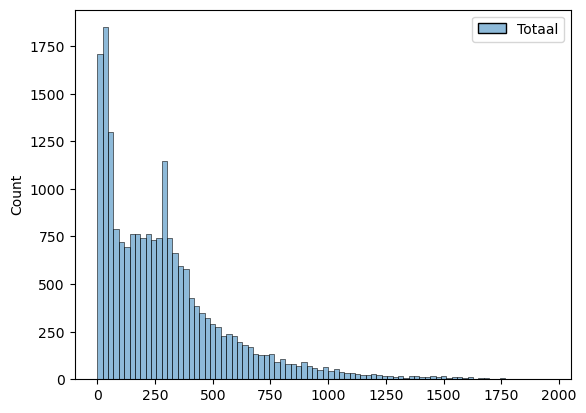

In [56]:
sns.histplot(train_data.loc[:,['Totaal']])

#### Time series plot

Here we plot the sum of the measurements at Coupure Links across each month. As we can see, the numbers fluctuate heavily by seasonality. School/working months such as September and October are notable hotspots, whilst notorious holiday months such as December, July and August are noticeably more barren. This highlights the need for features that are highly partial to the summer months (such as July itself), as it lies at the lower extremum of the yearly count spectrum, thus making the risk of overfitting quite significant.

   month_year  month  year    Totaal month_year_dt
4     03-2021      3  2021  190974.0    2021-03-01
7     04-2021      4  2021  165128.0    2021-04-01
10    05-2021      5  2021  174651.0    2021-05-01
13    06-2021      6  2021  220065.0    2021-06-01
16    07-2021      7  2021  155539.0    2021-07-01


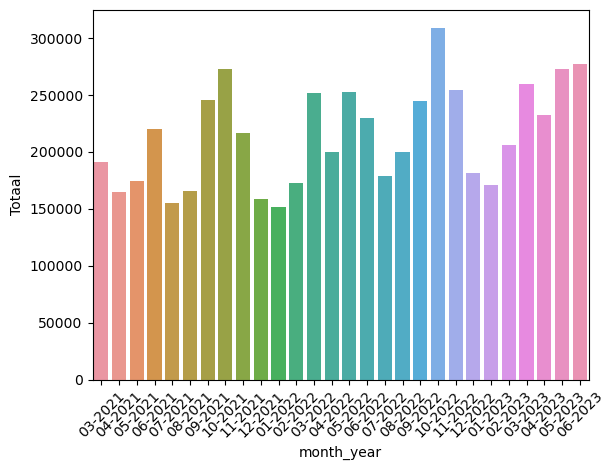

In [57]:
sum_by_month = train_data.groupby(['month_year', 'month', 'year']).agg({'Totaal': 'sum'}).reset_index()

sum_by_month['month_year_dt'] = pd.to_datetime(sum_by_month['month_year'], format='%m-%Y')

sum_by_month = sum_by_month.sort_values(by='month_year_dt')

print(sum_by_month.head())

sns.barplot(x = "month_year", y = "Totaal", data = sum_by_month)
plt.xticks(rotation=45)
%matplotlib inline

#### Heatmap Plot: Correlation Matrix

Next, we visualize the correlation between all numerical features and the response by use of a correlation matrix heatmap. There is some multi-colinearity, but nothing too distressing.

['temperature_2m', 'apparent_temperature', 'precipitation', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'is_day', 'hour', 'hour_sin', 'hour_cosin', 'month', 'is_weekday', 'is_weekend', 'is_school_hours', 'is_university_lessons', 'is_Ghent_event', 'is_public_holiday', 'is_bridge_day', 'is_school_holiday', 'is_bouwverlof', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Fall', 'Spring', 'Summer', 'Winter', 'LaggedTotaal_CL_year']


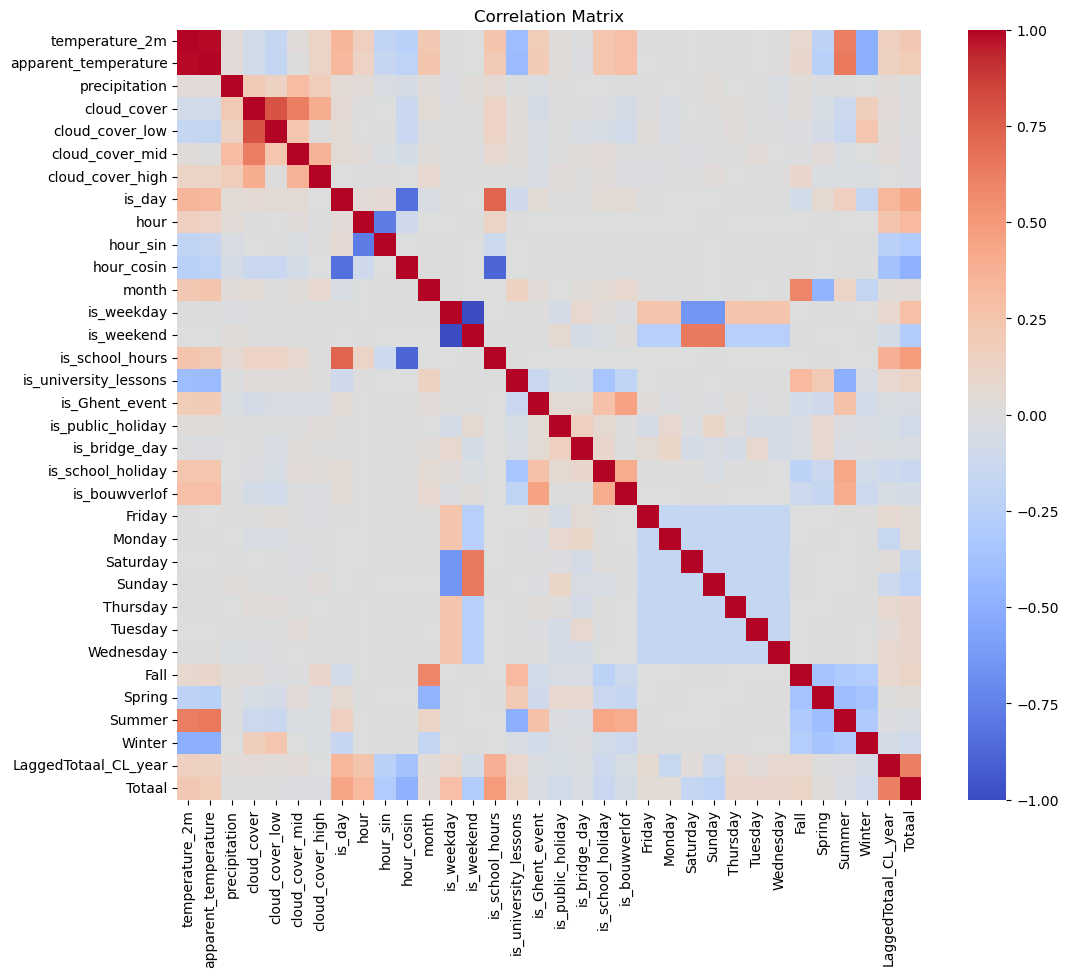

In [58]:
all_features = list(train_data.select_dtypes(include='number').columns)
elements_to_remove = ["Totaal"]
all_features = [feature for feature in all_features if feature not in elements_to_remove]
print(all_features)

cormat = train_data.loc[:, all_features + ["Totaal"]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(cormat, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Pairwise Plot: Weather and Temporal

As already implied, continuous/discrete weather and temporal features do seem to influence the response variable at times, but their relationship appears to often be non-linear. For example, low temperatures result in a decline of cyclists, but so do very high temperatures. What's more, only the activity maxima are influenced, as nighttime activity will be more indifferent to temperature fluctuations than daytime activity. This finding incentivizes us to consider employing a non-linear model, such as a decision tree method.

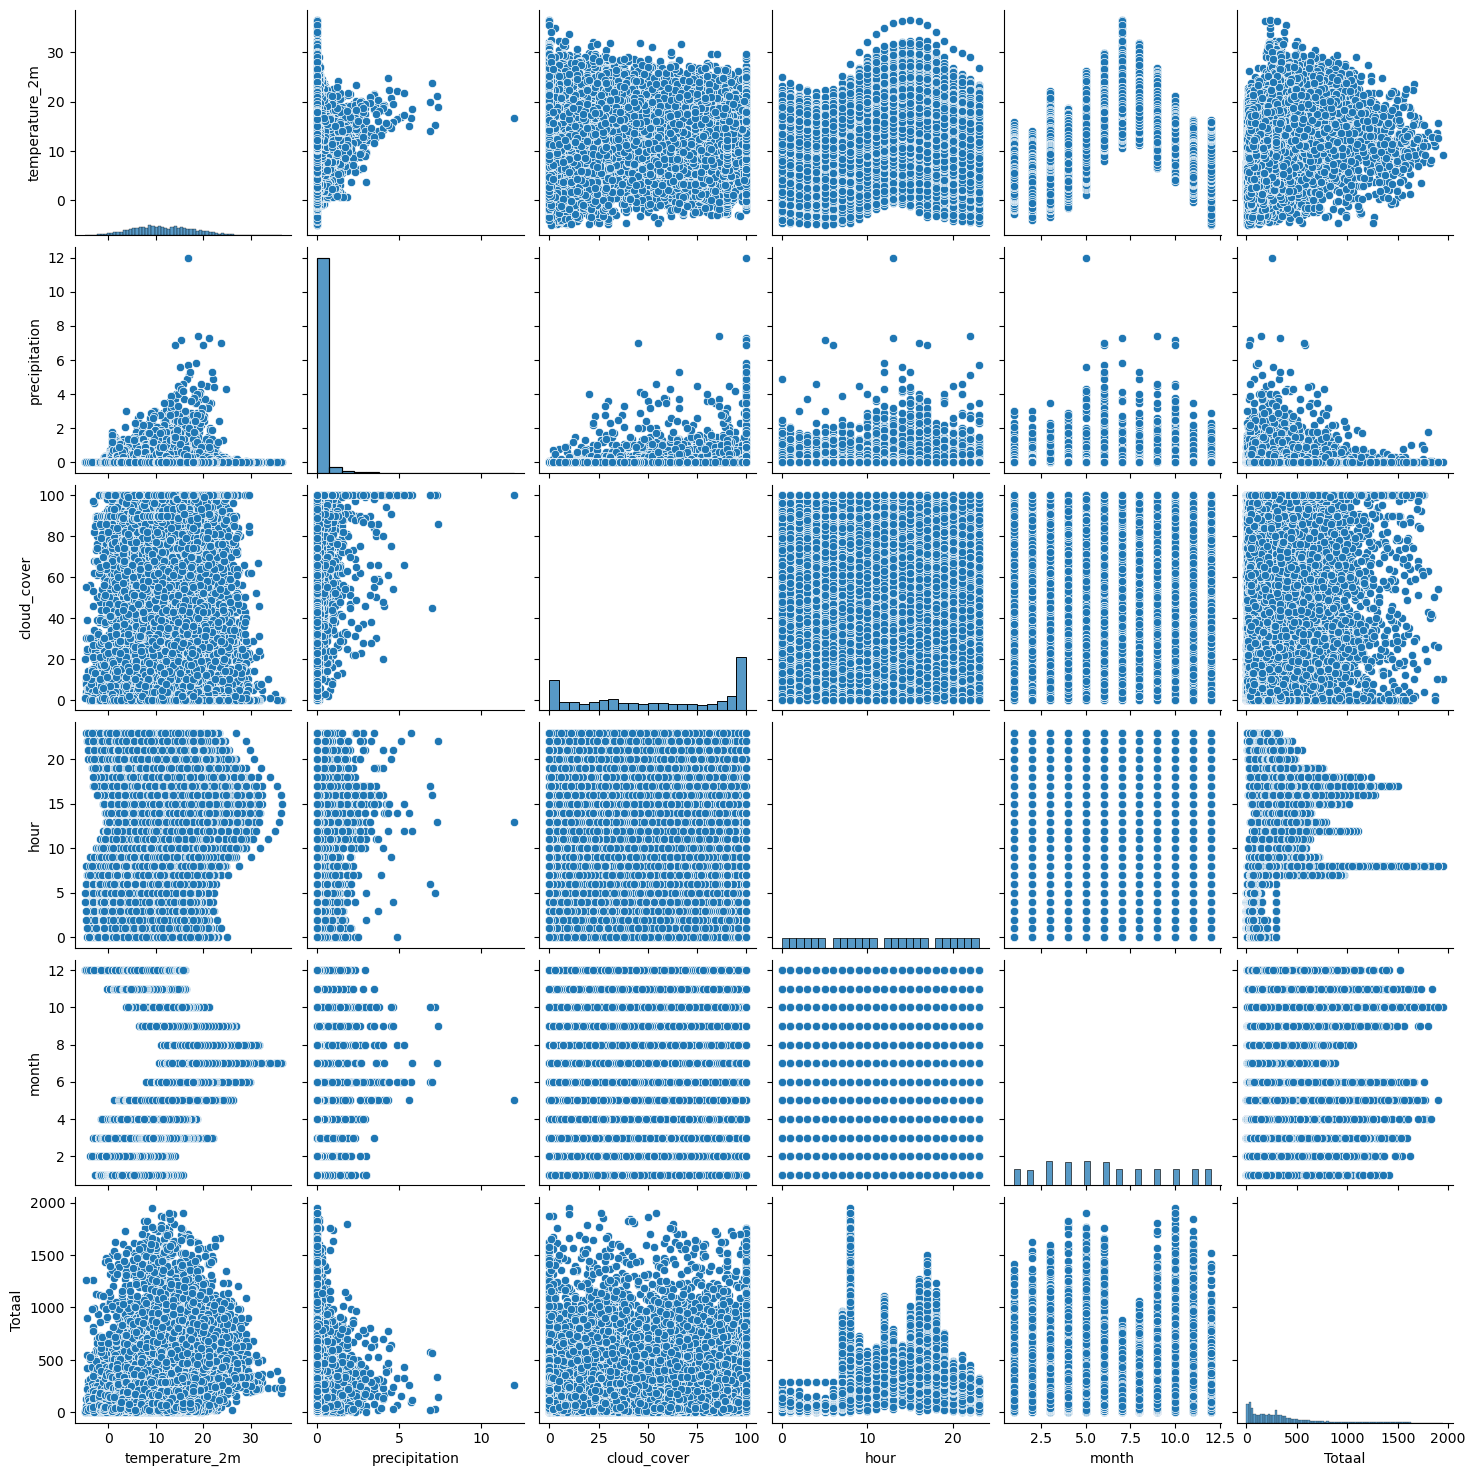

In [59]:
plot_features = ['temperature_2m', 'precipitation', 'cloud_cover', 'hour', 'month']
sns.pairplot(train_data.loc[:,plot_features + ["Totaal"]])

#### Pairwise Plot: Booleans

Similarly, we can state for the booleans that the maxima of the response are influenced by them, but the minima stay indifferent.

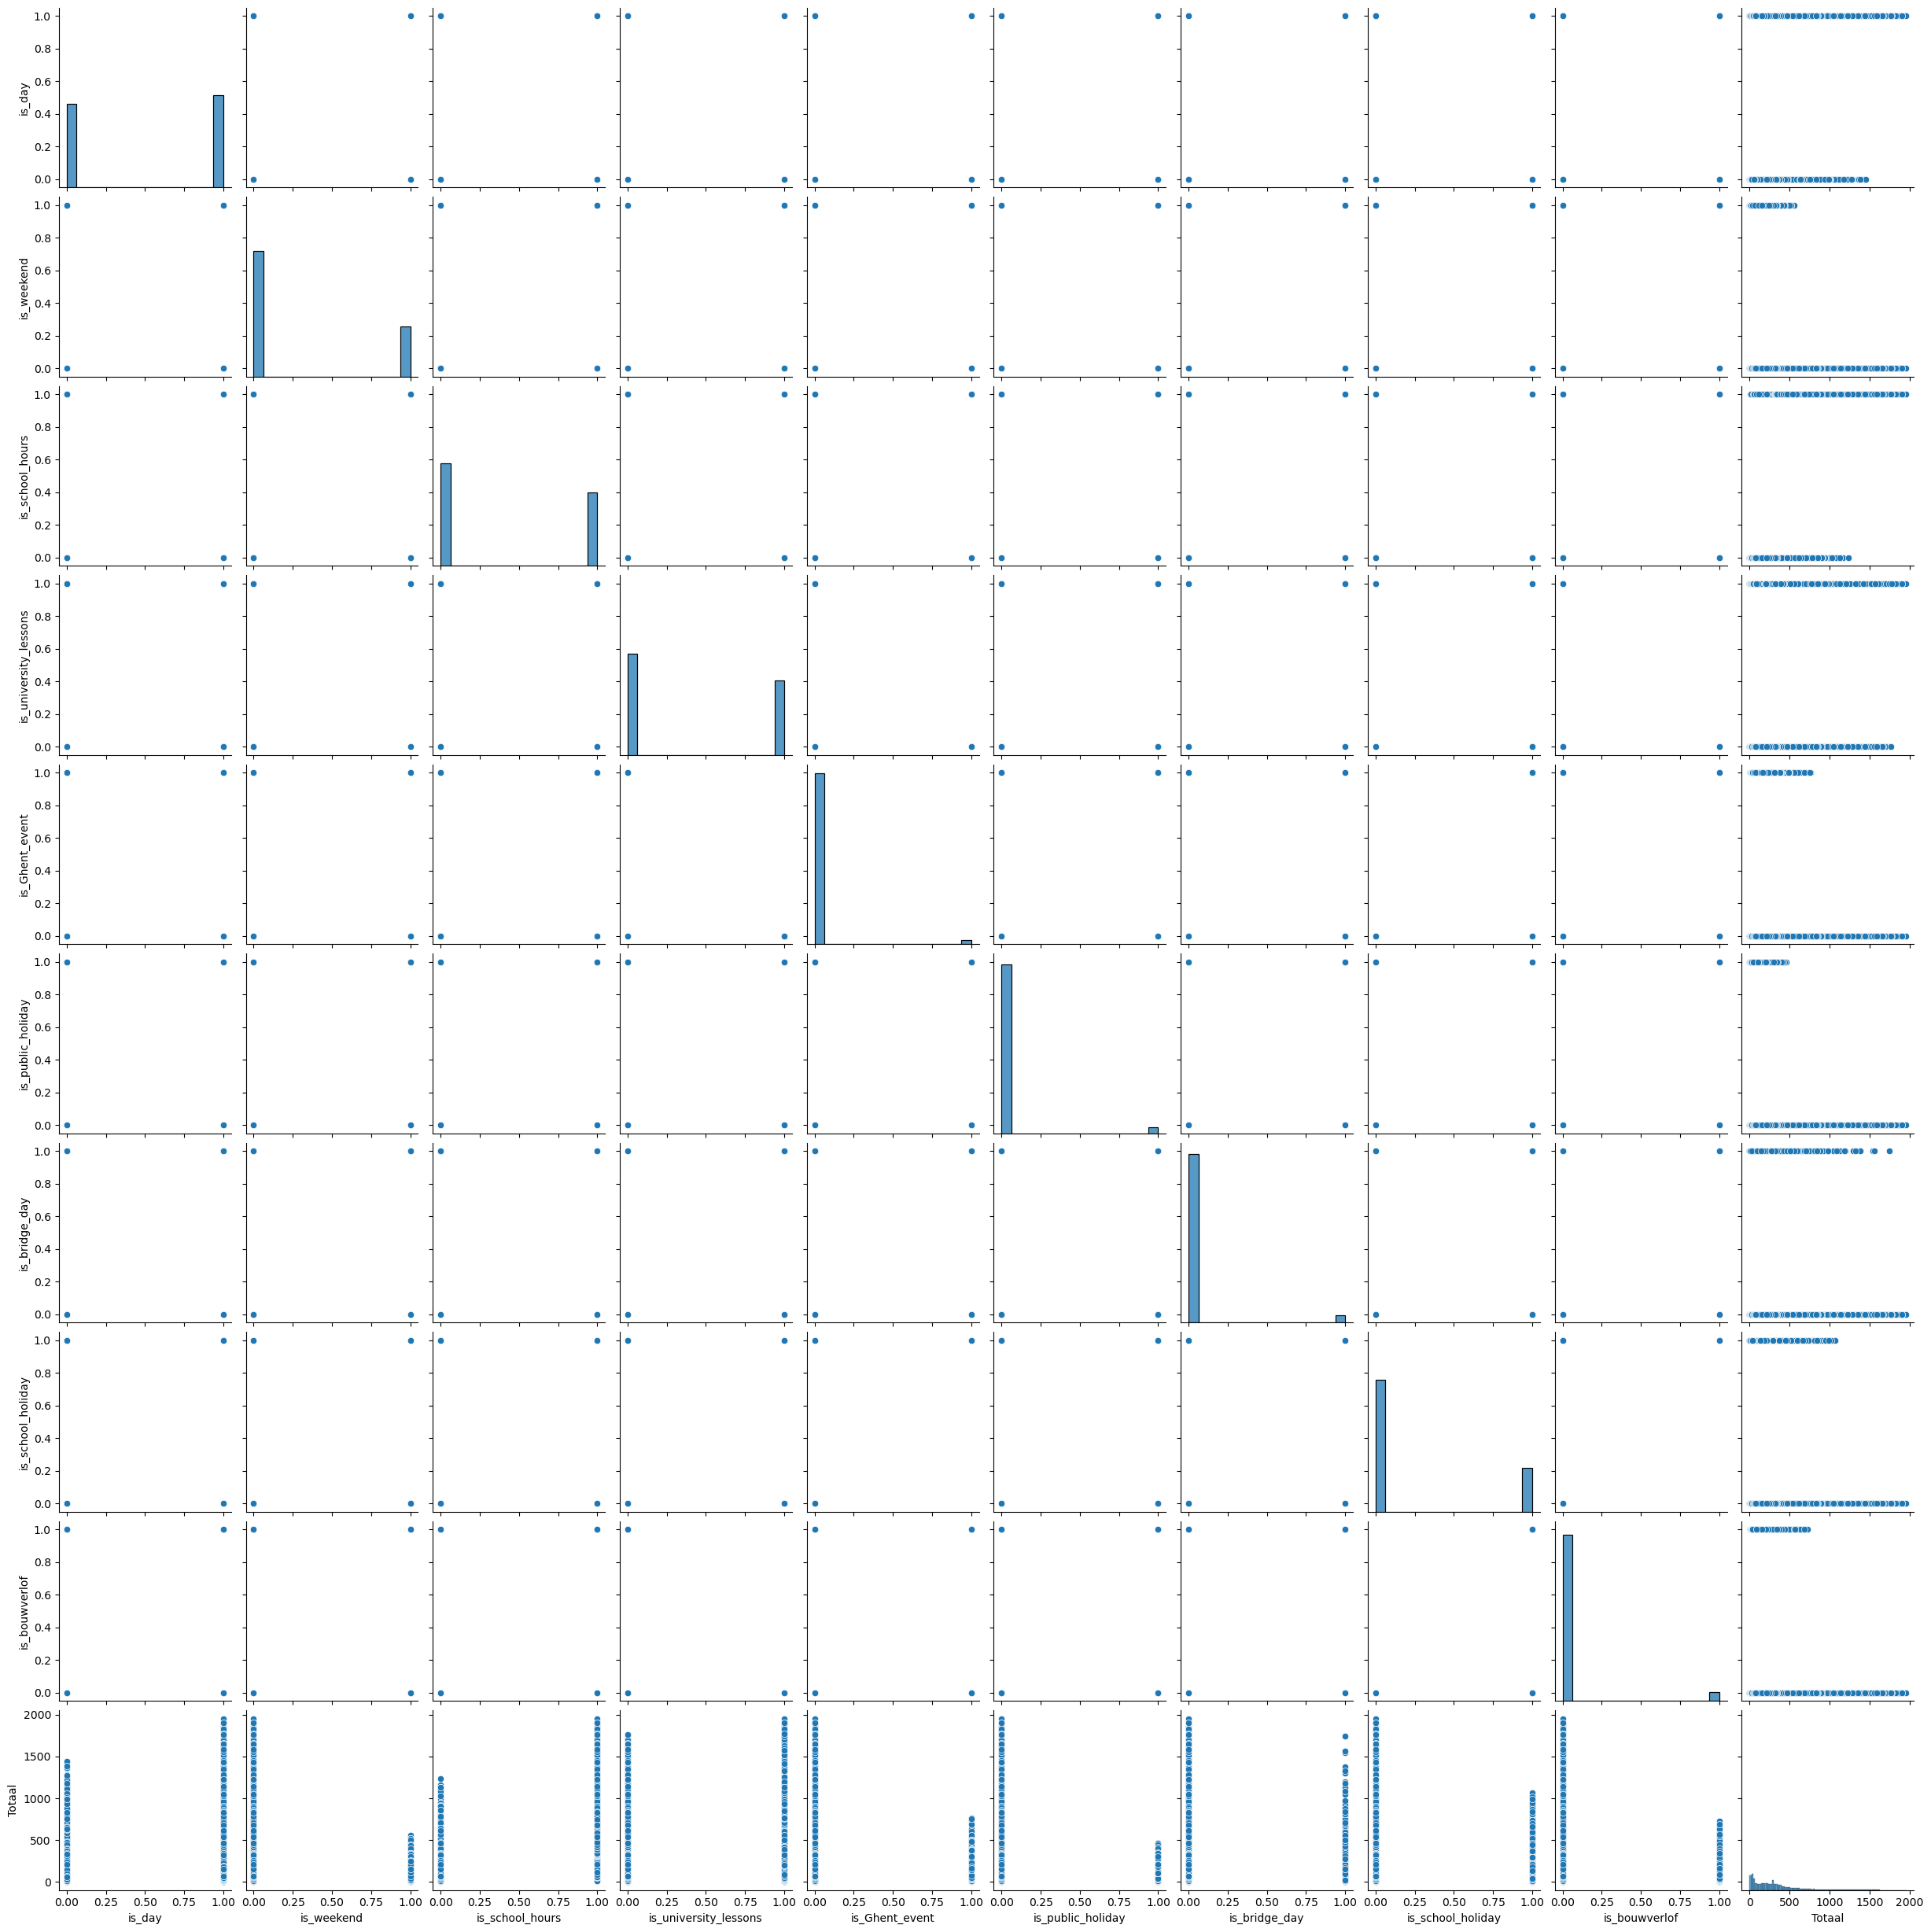

In [60]:
plot_features = ['is_day', 'is_weekend', 'is_school_hours', 'is_university_lessons', 'is_Ghent_event', 'is_public_holiday', 'is_bridge_day', 'is_school_holiday', 'is_bouwverlof']
sns.pairplot(train_data.loc[:, plot_features + ["Totaal"]])

### Interaction

Pairwise interaction terms are generated for this subset of features and added to the trainig and test set.

In [61]:
# poly = PolynomialFeatures(interaction_only=True, include_bias = False)

# poly_features = all_features

# train_poly = poly.fit_transform(train_data[poly_features])
# test_poly = poly.fit_transform(test_data[poly_features])

# interaction_feature_names = poly.get_feature_names_out()
# poly_train = pd.DataFrame(train_poly, columns=interaction_feature_names)
# poly_test = pd.DataFrame(test_poly, columns=interaction_feature_names)

# train_data = pd.concat([train_data.drop(columns=poly_features), poly_train], axis=1)
# test_data = pd.concat([test_data.drop(columns=poly_features), poly_test], axis=1)

all_features = list(train_data.select_dtypes(include='number').columns)
elements_to_remove = ["Totaal", "month"]
all_features = [feature for feature in all_features if feature not in elements_to_remove]
print(all_features)

['temperature_2m', 'apparent_temperature', 'precipitation', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'is_day', 'hour', 'hour_sin', 'hour_cosin', 'is_weekday', 'is_weekend', 'is_school_hours', 'is_university_lessons', 'is_Ghent_event', 'is_public_holiday', 'is_bridge_day', 'is_school_holiday', 'is_bouwverlof', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Fall', 'Spring', 'Summer', 'Winter', 'LaggedTotaal_CL_year']


## Model Pipeline Construction

### Model Selection

Many models were tested and compared throughout development, including:

LM
- Linear Regression
- Ridge Regression
- Lasso Regression

GLM
- Poisson Regression
- Negative Binomial Regression
- Tweedie Regression

DT
- Decision Tree Regression

Ensembl
- Random Forest Regression
- Gradient Boosting Regression

Others
- SVM Regression
- Gaussian Process Regression


In the end, ensembl models were the most consistently solid, with Gradient Boosting Regression turning out to return the overall best performance. Linear models, especially Ridge Regression, did admirably, but most likely fell short due to some of the underlying non-linear relationships. GLMs such as Poisson Regression models, despite being theoretically sound when considering the count nature of the response, came in just after LMs. This is most likely due to the distribution not perfectly emulating a binomial distribution of any kind, as a result of data imputation and outliers. Running these models with less crude imputation and outlier removal still performed worse than Gradient Boosting Regression, so these methods were dropped. Perhaps with the perfect binomial mixture model, GLMs would take the crown. Other methods such as SVR and Gaussian Process Regression were quickly dropped as a result of their high computational dependence with large feature spaces coupled with mediocre performance.

### Feature Normalization

To normalize features, sklearn's StandardScaler is applied to the training and test sets. This function standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:
$$
z = (x - u) / s
$$

u = mean of the training samples

s = standard deviation of the training samples

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Many elements used in the objective function of a learning algorithm (such as L1 regularizers, which we will be using in our pipeline for feature selection) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

### Feature Selection

Inherent to ensembl methods is that every feature is given an importance score, by which features are automatically "weighted" in the model. Thus, less important features will already be handled accordingly. Despite this, to reduce computational burden (and because it seems to be advantageous in practice), features are filtered out of the training and test set using Lasso Regression Regularization before the Gradient Boosting Regression model is trained, thus filtering out a number of "bad" features and reducing training time. This is done using the SelectFromModel function in conjunction with the Lasso model function, courtesy of sklearn.

### Cross-validation

In practice, it is always advisable to use cross-validation for final model selection. After all, in a real life scenario, one has no access to the true set one wants to predict. Below is an implementation of said cross-validation pipeline. Ideally, we would give an input grid of as many hyperparameter ranges with as high as possible resolution, and have no choice but to accept that the optimal hyperparameters returned will be as close to the best parameters for our test set as we are able to infer based on the knowledge available to us.

However, as we do not have access to a NASA supercomputer, and the competitive nature of the competition, this chunk is but a meager homage to good practice. Ideally, we would range the maximum tree depth, the number of estimators, the learning rate, and more in even tinier increments and across larger ranges, but one must abide by hardware constraints.

In [62]:
X_train = train_data.loc[:, all_features]
y_train = train_data["Totaal"]

selector = make_pipeline(StandardScaler(), SelectFromModel(Lasso()))
selector.fit(X_train, y_train)

model_to_tune = GradientBoostingRegressor()
param_grid = {"max_depth": np.arange(3, 8, 1),
              "learning_rate": np.arange(0.01, 0.1, 0.01),
              "n_estimators": np.arange(50, 150, 25),}

best_params = nested_kfold_cv(model_to_tune, param_grid, selector.transform(X_train), y_train)

max_depth_CV = best_params["max_depth"]
learning_rate_CV = best_params["learning_rate"]
n_estimators_CV = best_params["n_estimators"]

### Training: Best Cross-Validated Model

To train the model, a pipeline is contructed including the aforementioned scaler, feature selection and model fitting. The hyperparameters here are the ones estimated to be optimal from nested cross-validation.

In [ ]:
X_train = train_data.loc[:, all_features]
X_test = test_data.loc[:, all_features]

y_train = train_data["Totaal"]
y_test = gtest_data["Totaal"]

pipeline = make_pipeline(StandardScaler(), SelectFromModel(Lasso()), GradientBoostingRegressor(max_depth = 6, 
                                                                                               learning_rate = 0.1, 
                                                                                               n_estimators = 100
                                                                                               ))

pipeline.fit(X_train, y_train)

### Predictions: Best Cross-Validated Model

In [ ]:
y_hat_train = pipeline.predict(X_train) # predict training data

y_hat_test = pipeline.predict(X_test) # predict test data

R_train = pipeline.score(X_train, y_train) # Training set R²
R_test = pipeline.score(X_test, y_test) # Test set R²

best_features = X_train.columns[pipeline.named_steps['selectfrommodel'].get_support()]
feature_importances = pipeline.named_steps['gradientboostingregressor'].feature_importances_
feature_matrix = pd.DataFrame(data = {"feature_importances": feature_importances, "best_features": best_features}).sort_values(by = "feature_importances", ascending = False)

print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))
print(feature_matrix)
print(list(feature_matrix["best_features"]))

save_predictions("GBReg_CV", test_data, y_hat_test)

plot_diff(y_train, y_hat_train, y_test, y_hat_test)

### Training: Best Theoretical Model

We could call it a day here, but we are curious about the maximum potential that our model can offer. In the following training chunk, the hyperparameters are curated manually to emulate the best possible theoretical performance for our particular TEST set, not the regular or cross-validated training set. To be clear, this is NOT good modelling practice. This was done simply in the interest of the competition, to show off this particular model's highest theoretical performance for the month of July. As explained previously, it would be more correct to instead use hyperparameters obtained from extensive cross-validation. Therefore, for anything besides the purposes of the leaderboard standing, this model is fraudulently trained.

In [225]:
X_train = train_data.loc[:, all_features]
X_test = test_data.loc[:, all_features]

y_train = train_data["Totaal"]
y_test = gtest_data["Totaal"]

pipeline = make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha = 0.3)), GradientBoostingRegressor(max_depth = 8, 
                                                                                               learning_rate = 0.10, 
                                                                                               n_estimators = 100,
                                                                                               verbose = 0
                                                                                               ))

pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel',
                 SelectFromModel(estimator=Lasso(alpha=0.3))),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=8))])

### Predictions: Best Theoretical Model

Now that the model is trained, we can finally evaluate the results. It seems that features such as the hour of the day, lagged bike measurements, holidays and weekends were most useful in the construction of the boosted decision trees within the model. From our logarithmic error plots, we conclude that our model mostly overestimates counts in July 2023, most likely due to the summer months being an anomaly compared to the others (as predicted). One could say that the model is overfitted on the normal working months. This would obviously be easily solved by removing all months but July (and perhaps August) from the training set. However, to keep the model generalizable to future months other than July, and thus more reusable, it is opted to keep the training range as large as possible.

Train set R²: 0.9754339088771895
Test set R²: 0.9274508541627068
    feature_importances          best_features
6              0.337284                   hour
25             0.215997   LaggedTotaal_CL_year
8              0.119950             hour_cosin
9              0.115143             is_weekday
15             0.040046      is_school_holiday
7              0.032223               hour_sin
10             0.029283        is_school_hours
0              0.021965   apparent_temperature
13             0.016211      is_public_holiday
22             0.014471                   Fall
11             0.008216  is_university_lessons
3              0.007136        cloud_cover_mid
17             0.006689                 Friday
1              0.005074          precipitation
21             0.004605                Tuesday
2              0.004104        cloud_cover_low
20             0.004085               Thursday
14             0.003715          is_bridge_day
24             0.003363                 Wi

d:\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


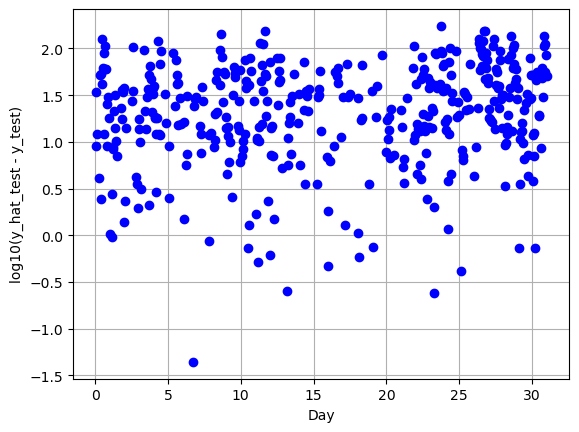

d:\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


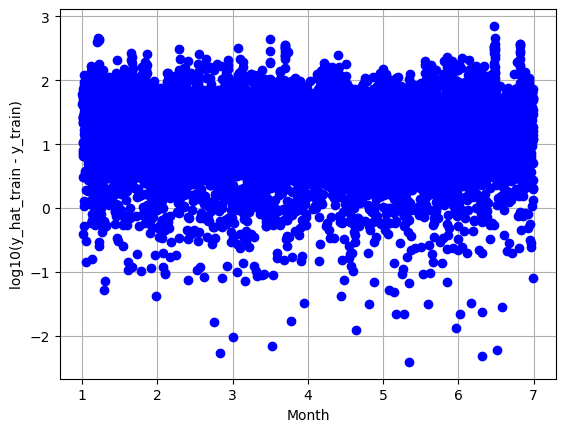

In [226]:
y_hat_train = pipeline.predict(X_train) # predict training data

y_hat_test = pipeline.predict(X_test) # predict test data

R_train = pipeline.score(X_train, y_train) # Training set R²
R_test = pipeline.score(X_test, y_test) # Test set R²

best_features = X_train.columns[pipeline.named_steps['selectfrommodel'].get_support()]
feature_importances = pipeline.named_steps['gradientboostingregressor'].feature_importances_
feature_matrix = pd.DataFrame(data = {"feature_importances": feature_importances, "best_features": best_features}).sort_values(by = "feature_importances", ascending = False)

print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))
print(feature_matrix)
print(list(feature_matrix["best_features"]))

save_predictions("GBReg_BT", test_data, y_hat_test)

plot_diff(y_train, y_hat_train, y_test, y_hat_test)

## Final Reflections

This pipeline initially did include features from other bike counters (so excluding those from Coupure Links), with them including measurements from July 2023 for the test set. The reasoning was that the narrative of the project went as follows: The bike counter at Coupure Links broke down for the whole month of July 2023. Within this fictional context, the problem becomes rather a data imputation problem, rather than a traditional forecasting problem. Given this narrative, one could assume that every other bike counter besides the one at the Coupure Links was still operational throughout July 2023, and thus fair game as a non-timeshifted feature. Regardless, since this was refuted, the model had to undergo some last minute changes, which did decrease its overall performance quite significantly.